In [2]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA 
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.data_providers import YahooDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [21]:
# set number of assets (= number of qubits)
num_assets = 8
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = ["GOOG", "MSFT", "AAPL", "WMT", "AMD", "AAL", "AXP", "INTC"]
data = YahooDataProvider(
    tickers=stocks,
    start=datetime.datetime(2021, 1, 1),
    end=datetime.datetime(2021, 12, 31)
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

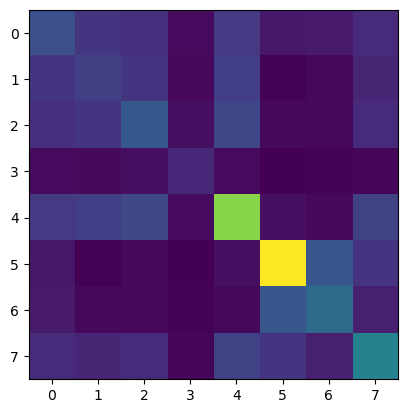

In [22]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [23]:
q = 0.7  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp


<QuadraticProgram: minimize 0.0001563862017557219*x_0^2 + 0.000197291030296925..., 8 variables, 1 constraints, 'Portfolio optimization'>

In [24]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [25]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 1. 0. 0. 1. 0. 1. 0.], value -0.0060

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 1 0 1 0]	-0.0060		1.0000
[1 1 1 1 1 1 1 1]	16.2573		0.0000
[0 1 1 1 1 1 1 1]	9.1435		0.0000
[1 0 1 1 1 0 1 0]	1.0112		0.0000
[0 0 1 1 1 0 1 0]	-0.0037		0.0000
[1 1 0 1 1 0 1 0]	1.0107		0.0000
[0 1 0 1 1 0 1 0]	-0.0043		0.0000
[1 0 0 1 1 0 1 0]	-0.0045		0.0000
[0 0 0 1 1 0 1 0]	1.0136		0.0000
[1 1 1 0 1 0 1 0]	1.0099		0.0000
[0 1 1 0 1 0 1 0]	-0.0052		0.0000
[1 0 1 0 1 0 1 0]	-0.0054		0.0000
[0 0 1 0 1 0 1 0]	1.0125		0.0000
[0 1 0 0 1 0 1 0]	1.0120		0.0000
[1 0 0 0 1 0 1 0]	1.0117		0.0000
[0 0 0 0 1 0 1 0]	4.0627		0.0000
[1 1 1 1 0 0 1 0]	1.0110		0.0000
[0 1 1 1 0 0 1 0]	-0.0039		0.0000
[1 0 1 1 0 0 1 0]	-0.0041		0.0000
[0 0 1 1 0 0 1 0]	1.0140		0.0000
[1 1 0 1 0 0 1 0]	-0.0046		0.0000
[0 1 0 1 0 0 1 0]	1.0135		0.0000
[1 0 0 1 0 0 1 0]	1.0133		0.0000
[0 0 0 1 0 0 1 0]	4.0644		0.0000
[1 1

[1 1 1 0 0 1 0 1]	1.0120		0.0000
[0 1 1 0 0 1 0 1]	-0.0030		0.0000
[1 0 1 0 0 1 0 1]	-0.0032		0.0000
[0 0 1 0 0 1 0 1]	1.0149		0.0000
[1 1 0 0 0 1 0 1]	-0.0037		0.0000
[0 1 0 0 0 1 0 1]	1.0143		0.0000
[0 0 0 0 0 0 0 0]	16.2626		0.0000


In [26]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = SPSA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 1. 0. 0. 1. 0. 1. 0.], value -0.0060

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 0 1 1 1]	-0.0024		0.2575
[1 0 0 1 0 1 1 0]	-0.0032		0.1053
[1 1 0 1 0 0 0 0]	1.0129		0.0946
[1 1 0 1 0 0 1 0]	-0.0046		0.0911
[0 1 1 0 0 0 1 1]	-0.0038		0.0649
[1 0 0 1 0 1 0 0]	1.0140		0.0476
[1 0 1 0 0 1 1 1]	1.0125		0.0413
[1 0 0 1 1 0 1 0]	-0.0045		0.0307
[1 0 0 1 1 0 0 0]	1.0131		0.0191
[1 1 1 0 0 0 1 1]	1.0112		0.0157
[1 1 0 1 0 0 1 1]	1.0121		0.0149
[0 0 1 0 0 1 1 0]	1.0138		0.0146
[1 1 0 1 1 0 0 0]	-0.0046		0.0139
[1 1 0 1 0 0 0 1]	-0.0033		0.0121
[0 0 1 0 1 0 1 1]	-0.0035		0.0114
[1 0 1 1 0 1 1 0]	1.0123		0.0114
[0 0 0 0 1 1 1 1]	-0.0027		0.0093
[0 0 0 0 0 1 1 1]	1.0151		0.0088
[1 0 1 1 0 1 0 0]	-0.0033		0.0062
[1 0 0 1 1 0 1 1]	1.0123		0.0055
[0 1 0 0 1 1 1 1]	1.0124		0.0055
[1 1 0 1 1 0 1 0]	1.0107		0.0053
[1 0 1 1 0 0 1 0]	-0.0041		0.0052
[1 0 0 1 1 1 1 0]	1.0119		0.0048
[0 

[0 0 0 0 0 1 0 0]	9.1472		0.0000
[1 1 0 0 1 1 0 0]	-0.0052		0.0000
[1 0 1 0 1 1 0 0]	-0.0046		0.0000
[0 1 1 1 0 0 1 1]	1.0128		0.0000
[1 1 1 0 1 0 0 0]	-0.0054		0.0000
[0 1 1 1 1 0 1 0]	1.0115		0.0000
[0 1 1 1 0 1 0 0]	-0.0031		0.0000
[0 1 1 1 0 0 1 0]	-0.0039		0.0000
[0 0 0 1 1 1 1 1]	1.0139		0.0000


In [ ]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 1. 0. 0. 1. 0. 1. 0.], value -0.0060

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 1 0 1 0]	-0.0060		0.0144
[1 1 1 0 0 0 1 0]	-0.0056		0.0144
[1 0 1 0 1 0 1 0]	-0.0054		0.0143
[1 1 1 0 1 0 0 0]	-0.0054		0.0143
[1 1 0 0 1 1 0 0]	-0.0052		0.0143
[0 1 1 0 1 0 1 0]	-0.0052		0.0143
[1 1 1 0 0 1 0 0]	-0.0049		0.0143
[1 1 0 0 0 1 1 0]	-0.0049		0.0143
[1 0 0 0 1 1 1 0]	-0.0047		0.0143
[1 0 1 0 1 1 0 0]	-0.0046		0.0143
[1 1 0 1 0 0 1 0]	-0.0046		0.0143
[1 1 0 0 0 0 1 1]	-0.0046		0.0143
[1 1 0 1 1 0 0 0]	-0.0046		0.0143
[0 1 0 0 1 1 1 0]	-0.0045		0.0143
[1 0 0 1 1 0 1 0]	-0.0045		0.0143
[0 1 1 0 1 1 0 0]	-0.0044		0.0143
[1 1 0 0 1 0 0 1]	-0.0045		0.0143
[1 0 0 0 1 0 1 1]	-0.0043		0.0143
[1 0 1 0 0 1 1 0]	-0.0043		0.0143
[0 1 0 1 1 0 1 0]	-0.0043		0.0143
[1 1 1 1 0 0 0 0]	-0.0043		0.0143
[1 1 1 0 0 0 0 1]	-0.0042		0.0143
[0 1 1 0 0 1 1 0]	-0.0042		0.0143
[0 1 0 0 1 0 1 1]	-0.004